# Train Tennis Agents
---

In this notebook, we train the Unity ML-Agent to solve two agents playing tennis

### 1. Import the Necessary Packages

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent_tennis import Agent

seed = 42

### 2. Instantiate the Environment and Agent

In [2]:
from unityagents import UnityEnvironment
# one arm
# env = UnityEnvironment(file_name=one_arm_file, seed=seed)

# many arms
env = UnityEnvironment(file_name="/home/robert/RL_ubuntu/udacity_drlnd_multi_agent/Tennis_Linux/Tennis.x86_64")
# no_graphics=True

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)

# size of each action
action_size = brain.vector_action_space_size

# examine the state space
states = env_info.vector_observations
state_size = states.shape[1]

# Set seed
agent = Agent(state_size=state_size, action_size=action_size, random_seed=seed)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 3. Train the Agent with DDPG

Run the code cell below to train the agent from scratch.  Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

Episode 100	Average Score: 0.00	Score: 0.00
Episode 200	Average Score: 0.00	Score: 0.00
Episode 300	Average Score: 0.00	Score: 0.00
Episode 400	Average Score: 0.01	Score: 0.00
Episode 500	Average Score: 0.00	Score: 0.00
Episode 600	Average Score: 0.02	Score: 0.10
Episode 700	Average Score: 0.07	Score: 0.10
Episode 800	Average Score: 0.09	Score: 0.00
Episode 900	Average Score: 0.15	Score: 0.09
Episode 1000	Average Score: 0.25	Score: 0.10
Episode 1045	Average Score: 0.51	Score: 2.70
Environment solved in 945 episodes!	Average Score: 0.51


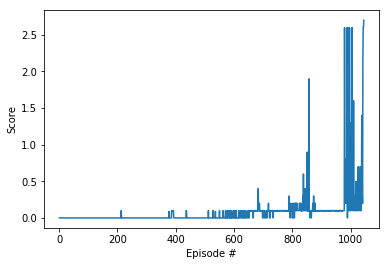

In [3]:
def ddpg(n_episodes=3000, max_t=10000, from_checkpoint=False):
    if from_checkpoint:
        agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
        agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))    
    scores_deque = deque(maxlen=100)
    scores_g = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            scores+= env_info.rewards
            if np.any(dones):
                break
        score = np.max(scores)
        scores_deque.append(score)
        scores_g.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
        if np.mean(scores_deque) > 0.5:
            torch.save(agent.actor_local.state_dict(), 'final_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'final_critic.pth')
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
    return scores_g

scores = ddpg()
#scores = ddpg(from_checkpoint=True)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [4]:
env.close()

In [5]:
print(agent.actor_local)
print(agent.critic_local)

Actor(
  (bn0): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=24, out_features=400, bias=True)
  (bn1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (bn2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=300, out_features=2, bias=True)
)
Critic(
  (fcs1): Linear(in_features=24, out_features=256, bias=True)
  (fc2): Linear(in_features=258, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
)


### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

Reload env if necessary

In [6]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

agent.actor_local.load_state_dict(torch.load('final_actor.pth'))
agent.critic_local.load_state_dict(torch.load('final_critic.pth'))

for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(states, add_noise=False)       # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))


Score (max over agents) from episode 1: 2.600000038743019
Score (max over agents) from episode 2: 2.7000000402331352
Score (max over agents) from episode 3: 2.600000038743019
Score (max over agents) from episode 4: 2.7000000402331352
Score (max over agents) from episode 5: 2.600000038743019


In [ ]:
env.close()